In [ ]:
'''
5. Text Similarity & Matching 
Dataset: Quora Question Pairs / SNLI / Custom Q&A data 
Goal: Use Transformer encoder to embed two texts and classify as similar or not. 
Key tasks: 
 Encode two input sequences using shared transformer 
 Compute similarity (e.g., via cosine or dense layer) 
 Binary classification (are these two texts semantically similar?) 
'''

In [1]:
# Example synthetic data generation
import random
vocab = [f"word{i}" for i in range(20)]
N = 2000  # number of pairs
max_len = 10

texts1, texts2, labels = [], [], []
for _ in range(N):
    # Generate a random sequence of length between 5 and max_len
    seq1 = random.choices(vocab, k=random.randint(5, max_len))
    if random.random() < 0.5:
        # Label = 1 (similar): create seq2 sharing many tokens with seq1
        common = random.sample(seq1, k=len(seq1)//2)
        seq2 = common + random.choices(vocab, k=len(seq1)-len(common))
        random.shuffle(seq2)
        label = 1
    else:
        # Label = 0 (not similar): random sequence with little guaranteed overlap
        seq2 = random.choices(vocab, k=len(seq1))
        label = 0
    texts1.append(" ".join(seq1))
    texts2.append(" ".join(seq2))
    labels.append(label)

print(texts1[0], "|", texts2[0], "|", labels[0])


word17 word17 word11 word9 word19 word6 word19 word2 word16 | word19 word10 word11 word9 word15 word9 word4 word5 word19 | 0


In [3]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fit tokenizer on all texts
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts1 + texts2)

# Convert texts to sequences of token IDs
seqs1 = tokenizer.texts_to_sequences(texts1)
seqs2 = tokenizer.texts_to_sequences(texts2)

# Pad sequences to fixed length
max_len = 10
padded1 = pad_sequences(seqs1, maxlen=max_len, padding='post')
padded2 = pad_sequences(seqs2, maxlen=max_len, padding='post')
labels = np.array(labels)


In [4]:
import numpy as np

def get_positional_encoding(max_len, d_model):
    """Generate sinusoidal positional encodings."""
    pos_enc = np.zeros((max_len, d_model))
    for pos in range(max_len):
        for i in range(0, d_model, 2):
            angle = pos / np.power(10000, (2*i)/d_model)
            pos_enc[pos, i]   = np.sin(angle)
            pos_enc[pos, i+1] = np.cos(angle)
    return pos_enc

d_model = 64  # embedding dimension
pos_encoding = get_positional_encoding(max_len, d_model)


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense

class MultiHeadSelfAttention(Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        
        # Learnable weight matrices for Q, K, V and the final output
        self.wq = Dense(d_model, use_bias=False)
        self.wk = Dense(d_model, use_bias=False)
        self.wv = Dense(d_model, use_bias=False)
        self.dense = Dense(d_model)  # final linear projection
    
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (num_heads, depth).
        Transpose to shape (batch, num_heads, seq_len, depth).
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        # inputs shape: (batch_size, seq_len, d_model)
        batch_size = tf.shape(inputs)[0]
        
        # Linear projections
        q = self.wq(inputs)  # (batch, seq_len, d_model)
        k = self.wk(inputs)  # (batch, seq_len, d_model)
        v = self.wv(inputs)  # (batch, seq_len, d_model)
        
        # Split into heads
        q = self.split_heads(q, batch_size)  # (batch, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # Scaled dot-product attention: QK^T / sqrt(depth)
        scores = tf.matmul(q, k, transpose_b=True)  # (batch, num_heads, seq_len, seq_len)
        scores = scores / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        weights = tf.nn.softmax(scores, axis=-1)     # attention weights
        
        # Weighted sum of values
        attention_output = tf.matmul(weights, v)     # (batch, num_heads, seq_len, depth)
        # Concatenate heads
        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
        concat = tf.reshape(attention_output, (batch_size, -1, self.num_heads * self.depth))
        
        # Final linear layer
        output = self.dense(concat)  # (batch, seq_len, d_model)
        return output


In [6]:
from tensorflow.keras.layers import LayerNormalization, Dropout

def point_wise_feed_forward(d_model, d_ff):
    return tf.keras.Sequential([
        Dense(d_ff, activation='relu'),  # d_ff is the hidden size (e.g., 2048)
        Dense(d_model)
    ])


In [7]:
class TransformerEncoder(Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout_rate=0.1):
        super().__init__()
        self.mha = MultiHeadSelfAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward(d_model, d_ff)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
    
    def call(self, x, training=False):
        # Multi-head self-attention sub-layer
        attn_output = self.mha(x)                   # (batch, seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)     # (batch, seq_len, d_model)
        
        # Feed-forward sub-layer
        ffn_output = self.ffn(out1)                 # (batch, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)   # (batch, seq_len, d_model)
        
        return out2


In [8]:
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Concatenate
from tensorflow.keras.models import Model

vocab_size = len(tokenizer.word_index) + 1  # tokenizer vocabulary size
d_model = 64
num_heads = 4
d_ff = 256

# Shared embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=d_model, mask_zero=True)

# Input layers for two texts
input1 = Input(shape=(max_len,), name="text1")
input2 = Input(shape=(max_len,), name="text2")

# Embed and add positional encoding
# Note: we assume pos_encoding is a NumPy array; we can make it a constant tensor.
embed1 = embedding_layer(input1)  # (batch, max_len, d_model)
embed2 = embedding_layer(input2)
embed1 *= tf.math.sqrt(tf.cast(d_model, tf.float32))
embed2 *= tf.math.sqrt(tf.cast(d_model, tf.float32))
embed1 += pos_encoding  # broadcasting (max_len, d_model) to batch
embed2 += pos_encoding

# Shared Transformer encoder (we stack two layers here)
encoder = TransformerEncoder(d_model, num_heads, d_ff)
x1 = encoder(embed1)
x1 = encoder(x1)  # second layer (can reuse layer or create new)
x2 = encoder(embed2)
x2 = encoder(x2)

# Pooling: average over tokens
vec1 = GlobalAveragePooling1D()(x1)  # (batch, d_model)
vec2 = GlobalAveragePooling1D()(x2)

# Combine vectors and classify
merged = Concatenate()([vec1, vec2])
dense = Dense(64, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(dense)  # similarity score

model = Model(inputs=[input1, input2], outputs=output)


In [9]:
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    [padded1, padded2], labels,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5177 - loss: 0.7250 - val_accuracy: 0.4550 - val_loss: 0.6945
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5050 - loss: 0.6949 - val_accuracy: 0.4975 - val_loss: 0.7171
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5100 - loss: 0.7037 - val_accuracy: 0.5000 - val_loss: 0.7060
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5334 - loss: 0.6923 - val_accuracy: 0.5100 - val_loss: 0.7260
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5465 - loss: 0.6935 - val_accuracy: 0.4975 - val_loss: 0.7077
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5335 - loss: 0.6918 - val_accuracy: 0.4825 - val_loss: 0.7147
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5962 - loss: 0.6735 - val_accuracy: 0.4775 - val_loss: 0.6991
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5349 - loss: 0.6816 - val_accuracy: 0.5075 - v

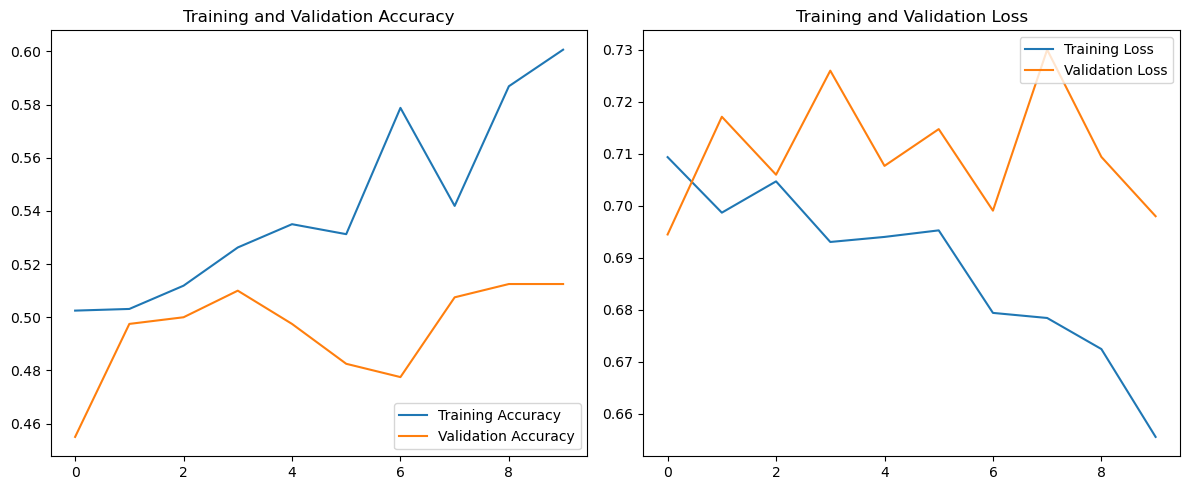

In [10]:
import matplotlib.pyplot as plt

# Access training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()
